<a href="https://colab.research.google.com/github/ra1ph2/Segmentation_Gandhinagar_IIRS/blob/master/Segmentation_Gandhinagar_IIRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Satelite Image Segmentation Workflow

In [0]:
!pip install fastai

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


### Import Files From Local Machine

In [0]:
from google.colab import files
uploaded = files.upload()


Saving data_gandhi.zip to data_gandhi.zip


#### Unzipping the zip file uploaded

Change the file_path to the name of the zip file uploaded


In [0]:
file_path = 'data_gandhi.zip' 

import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded[file_path]), "r")
zf.extractall()

### Data Preprocessing

**All the data preprocessing steps are done to make two folders train and labels. The commands below are for the specific zip file format and if its different then the code for correct path names must be changed.**

If the data is already processed skip to the the path block .
Otherwise create a folder with "\_pre" suffix using the commands below and replacing the folder_name with required replacement. Run these cells again for the labels folder as well.

In [0]:
%mkdir train
%mkdir label
%mv /content/data_gandhi/gandhi.tif /content/train/
%mv /content/data_gandhi/building.tif /content/label/
%mv /content/data_gandhi/road.tif /content/label/
%mv /content/data_gandhi/field.tif /content/label/
%mv /content/data_gandhi/tree.tif /content/label/


In [0]:
%mkdir label_pre
%mkdir train_pre
%cd train
!ls

/content/train
gandhi.tif


#### Script for converting Tiff to JPG files in a new folder

In [0]:
import os
from PIL import Image
from osgeo import gdal



options_list = ['-ot Byte','-of JPEG','-b 1 -b 2 -b 3','-scale'] 
options_string = " ".join(options_list)

yourpath = os.getcwd()
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        print(os.path.join(root, name))
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
            if os.path.isfile(os.path.splitext(os.path.join(root, name))[0] + ".jpg"):
                print ("A jpeg file already exists for %s" % name)
            # If a jpeg is *NOT* present, create one from the tiff.
            else:
                outfile = os.path.splitext(os.path.join(root+'_pre', name))[0] + ".jpg"
                gdal.Translate(outfile,
                            os.path.join(root, name),
                            options=options_string)

/content/train/gandhi.tif


#### Similiarly for the label files


In [0]:
%cd ..
%cd label

/content
/content/label


In [0]:
import os
from PIL import Image
from osgeo import gdal



options_list = ['-ot Byte','-of JPEG','-b 1','-scale'] 
options_string = " ".join(options_list)

yourpath = os.getcwd()
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        print(os.path.join(root, name))
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
            if os.path.isfile(os.path.splitext(os.path.join(root, name))[0] + ".png"):
                print ("A jpeg file already exists for %s" % name)
            # If a jpeg is *NOT* present, create one from the tiff.
            else:
                outfile = os.path.splitext(os.path.join(root+'_pre', name))[0] + ".png"
                gdal.Translate(outfile,
                            os.path.join(root, name),
                            options=options_string)

/content/label/tree.tif
/content/label/building.tif
/content/label/road.tif
/content/label/field.tif


In [0]:
%cd ..
%cd label_pre

/content
/content/label_pre


#### Thresholding the label masks to create binary masks

In [0]:
import os
import cv2

yourpath = os.getcwd()
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        print(os.path.join(root, name))
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".png":

          img = cv2.imread(str(os.path.join(root,name)),0)
          ret,thresh1 = cv2.threshold(img,2,255,cv2.THRESH_BINARY)
          # stats.itemfreq(thresh1)
          cv2.imwrite(str(os.path.join(root,name)),thresh1)

/content/label_pre/tree.png.aux.xml
/content/label_pre/building.png
/content/label_pre/road.png
/content/label_pre/road.png.aux.xml
/content/label_pre/field.png.aux.xml
/content/label_pre/tree.png
/content/label_pre/field.png
/content/label_pre/building.png.aux.xml


#### Combining the different binary masks into a single PNG file 

In [0]:
#TODO : Automate this process of combining the number of masks
import numpy as np

img = cv2.imread('building.png',0)
row,col = img.shape
res = np.zeros((row,col))
res = res.astype(int)
for i in range(row):
  for j in range(col):
     if (not res[i][j]) and (img[i][j]):
        res[i][j] = 1
img = cv2.imread('road.png',0)
for i in range(row):
  for j in range(col):
     if (not res[i][j]) and (img[i][j]):
        res[i][j] = 2
img = cv2.imread('field.png',0)
for i in range(row):
  for j in range(col):
     if (not res[i][j]) and (img[i][j]):
        res[i][j] = 3
img = cv2.imread('tree.png',0)
for i in range(row):
  for j in range(col):
     if (not res[i][j]) and (img[i][j]):
        res[i][j] = 4
cv2.imwrite('gandhi.png',res)


True

In [0]:
%cd ..
%mkdir label_pre1
%mv /content/label_pre/gandhi.png /content/label_pre1/

/content


####Combined Ground Truth Image

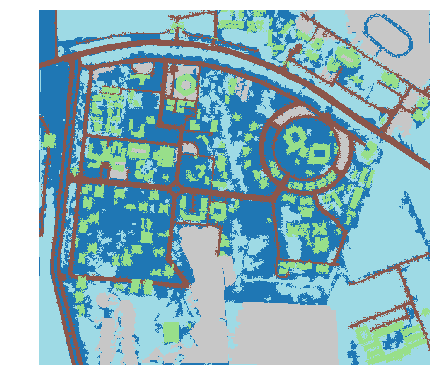

In [0]:
lnames = get_image_files(Path('/content/label_pre1'))
mask = open_mask(lnames[0])
mask.show(figsize = (7,7),alpha = 1)

In [0]:
%cd label_pre1

/content/label_pre1


#### Script for Splitting the image into tiles

Change the value of chopsize to decide the dimensions of the tile. Please select the chopsize as a divisor of the dimensions of the image for no outliers in the data.

In [0]:
from PIL import Image
import os

chopsize = 256
stride = 128

yourpath = os.getcwd()
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        print(os.path.join(root, name))
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".png":
            img = Image.open(os.path.join(root,name))
            width , height = img.size
            i = 0
            for x0 in range(0, width, stride):
                for y0 in range(0, height, stride):
                    if not((x0+chopsize > width) or (y0+chopsize > height)):
                        box = (x0, y0,
                                x0+chopsize if x0+chopsize <=  width else  width - 1,
                                y0+chopsize if y0+chopsize <= height else height - 1)
                        img.crop(box).save('%s_%d.png' % (os.path.splitext(os.path.join(root,name))[0], i))
                        i = i+1 
            os.remove(os.path.join(root,name)) 

/content/label_pre1/gandhi.png


In [0]:
%ls

gandhi_0.png   gandhi_23.png  gandhi_37.png  gandhi_50.png  gandhi_64.png
gandhi_10.png  gandhi_24.png  gandhi_38.png  gandhi_51.png  gandhi_65.png
gandhi_11.png  gandhi_25.png  gandhi_39.png  gandhi_52.png  gandhi_66.png
gandhi_12.png  gandhi_26.png  gandhi_3.png   gandhi_53.png  gandhi_67.png
gandhi_13.png  gandhi_27.png  gandhi_40.png  gandhi_54.png  gandhi_68.png
gandhi_14.png  gandhi_28.png  gandhi_41.png  gandhi_55.png  gandhi_69.png
gandhi_15.png  gandhi_29.png  gandhi_42.png  gandhi_56.png  gandhi_6.png
gandhi_16.png  gandhi_2.png   gandhi_43.png  gandhi_57.png  gandhi_70.png
gandhi_17.png  gandhi_30.png  gandhi_44.png  gandhi_58.png  gandhi_71.png
gandhi_18.png  gandhi_31.png  gandhi_45.png  gandhi_59.png  gandhi_7.png
gandhi_19.png  gandhi_32.png  gandhi_46.png  gandhi_5.png   gandhi_8.png
gandhi_1.png   gandhi_33.png  gandhi_47.png  gandhi_60.png  gandhi_9.png
gandhi_20.png  gandhi_34.png  gandhi_48.png  gandhi_61.png
gandhi_21.png  gandhi_35.png  gandhi_49.png  gandhi_62.pn

In [0]:
%cd ..
%cd train_pre

/content
/content/train_pre


#### Splitting the Satellite Images into tiles

In [0]:
from PIL import Image
import os

# infile = 'test_11_1_mask.png'
chopsize = 256
stride = 128

# img = Image.open(infile)
# width, height = img.size

yourpath = os.getcwd()
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        print(os.path.join(root, name))
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".jpg":
            img = Image.open(os.path.join(root,name))
            width , height = img.size
            i = 0
            for x0 in range(0, width, stride):
                for y0 in range(0, height, stride):
                    if not((x0+chopsize > width) or (y0+chopsize > height)):
                        box = (x0, y0,
                                x0+chopsize if x0+chopsize <=  width else  width - 1,
                                y0+chopsize if y0+chopsize <= height else height - 1)
                        img.crop(box).save('%s_%d.jpg' % (os.path.splitext(os.path.join(root,name))[0], i))
                        i = i+1 
            os.remove(os.path.join(root,name)) 

/content/train_pre/gandhi.jpg.aux.xml
/content/train_pre/gandhi.jpg


In [0]:
%ls

gandhi_0.jpg   gandhi_23.jpg  gandhi_37.jpg  gandhi_50.jpg  gandhi_64.jpg
gandhi_10.jpg  gandhi_24.jpg  gandhi_38.jpg  gandhi_51.jpg  gandhi_65.jpg
gandhi_11.jpg  gandhi_25.jpg  gandhi_39.jpg  gandhi_52.jpg  gandhi_66.jpg
gandhi_12.jpg  gandhi_26.jpg  gandhi_3.jpg   gandhi_53.jpg  gandhi_67.jpg
gandhi_13.jpg  gandhi_27.jpg  gandhi_40.jpg  gandhi_54.jpg  gandhi_68.jpg
gandhi_14.jpg  gandhi_28.jpg  gandhi_41.jpg  gandhi_55.jpg  gandhi_69.jpg
gandhi_15.jpg  gandhi_29.jpg  gandhi_42.jpg  gandhi_56.jpg  gandhi_6.jpg
gandhi_16.jpg  gandhi_2.jpg   gandhi_43.jpg  gandhi_57.jpg  gandhi_70.jpg
gandhi_17.jpg  gandhi_30.jpg  gandhi_44.jpg  gandhi_58.jpg  gandhi_71.jpg
gandhi_18.jpg  gandhi_31.jpg  gandhi_45.jpg  gandhi_59.jpg  gandhi_7.jpg
gandhi_19.jpg  gandhi_32.jpg  gandhi_46.jpg  gandhi_5.jpg   gandhi_8.jpg
gandhi_1.jpg   gandhi_33.jpg  gandhi_47.jpg  gandhi_60.jpg  gandhi_9.jpg
gandhi_20.jpg  gandhi_34.jpg  gandhi_48.jpg  gandhi_61.jpg
gandhi_21.jpg  gandhi_35.jpg  gandhi_49.jpg  gandhi_62.jp

#### Script for removing extra files created due to GDAL Translate

In [0]:
import os 

yourpath = os.getcwd()
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        print(os.path.join(root, name))
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".xml":
          os.remove(os.path.join(root,name))

/content/train_pre/gandhi_24.jpg
/content/train_pre/gandhi_13.jpg
/content/train_pre/gandhi_39.jpg
/content/train_pre/gandhi_0.jpg
/content/train_pre/gandhi_42.jpg
/content/train_pre/gandhi_7.jpg
/content/train_pre/gandhi_29.jpg
/content/train_pre/gandhi_28.jpg
/content/train_pre/gandhi_27.jpg
/content/train_pre/gandhi_45.jpg
/content/train_pre/gandhi_21.jpg
/content/train_pre/gandhi_40.jpg
/content/train_pre/gandhi_25.jpg
/content/train_pre/gandhi_56.jpg
/content/train_pre/gandhi_57.jpg
/content/train_pre/gandhi_54.jpg
/content/train_pre/gandhi_9.jpg
/content/train_pre/gandhi_23.jpg
/content/train_pre/gandhi_52.jpg
/content/train_pre/gandhi_12.jpg
/content/train_pre/gandhi_11.jpg
/content/train_pre/gandhi_19.jpg
/content/train_pre/gandhi_1.jpg
/content/train_pre/gandhi_37.jpg
/content/train_pre/gandhi_63.jpg
/content/train_pre/gandhi_62.jpg
/content/train_pre/gandhi_30.jpg
/content/train_pre/gandhi_36.jpg
/content/train_pre/gandhi_22.jpg
/content/train_pre/gandhi_18.jpg
/content/train

In [0]:
%cd ..

/content


### Path Block

Set the path of the training images folder at path_train and the labels of the same at path_labels.

In [0]:
path = Path('/content')
path_train = path/'train_pre'
path_labels = path/'label_pre1'
path_train
path_labels

PosixPath('/content/label_pre1')

#### Function for selecting the label images for respective images

Change the value after {x.stem} according to your data labels.
> Example


    Image name : **Delhi_10.jpg**
    Label name  : **Delhi_10_mask.png**
    y_func  = lambda x : path_labels/f'{x.stem}\_mask.png'

In [0]:
y_func = lambda x: path_labels/f'{x.stem}.png'

codes = array(['Void','Building','Road','Field','Tree'])

In [0]:
Inames = get_image_files(path_train)
Inames[:3]

[PosixPath('/content/train_pre/gandhi_24.jpg'),
 PosixPath('/content/train_pre/gandhi_13.jpg'),
 PosixPath('/content/train_pre/gandhi_39.jpg')]

In [0]:
Lnames = get_image_files(path_labels)
Lnames[:3]

[PosixPath('/content/label_pre1/gandhi_8.png'),
 PosixPath('/content/label_pre1/gandhi_63.png'),
 PosixPath('/content/label_pre1/gandhi_32.png')]

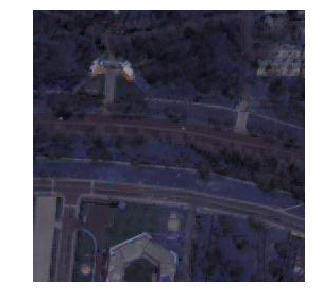

In [0]:
img = open_image(Inames[0])
img.show(figsize = (5,5))

In [0]:
from scipy import stats

img = cv2.imread(str(y_func(Inames[0])),0)
stats.itemfreq(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  after removing the cwd from sys.path.


array([[    0, 13843],
       [    1,  4623],
       [    2, 17203],
       [    3,  3275],
       [    4, 26592]])

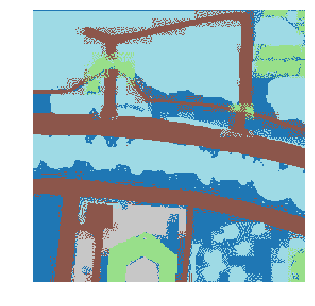

In [0]:
mask = open_mask(y_func(Inames[0]))
mask.show(figsize = (5,5),alpha = 1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([256, 256]), tensor([[[0, 0, 0,  ..., 0, 1, 0],
          [4, 4, 4,  ..., 1, 1, 1],
          [4, 4, 4,  ..., 1, 1, 1],
          ...,
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1]]]))

### First Training Cycle

In the first run we train the the UNet on half of the size of images. And after it is trained on it we move towards the normal size in the next cycle

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


#### Source object made to take files from the folder path_train and then the data is split into training and validation at a default value of 20% and then the labels are fetched using the lambda function defined before and the classes are provided

In [0]:
src = (SegmentationItemList.from_folder(path_train)
       .split_by_rand_pct()
       .label_from_func(y_func, classes=codes))

#### Data object made from source object and data augmentation is applied to both the images and the labels as its a segmetation task. The batch size os provided through bs variable and the data is normalized using ImageNet Stats as Resnet(Base Model in UNet) is trained on it.

In [0]:
data = (src.transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

#### Data visualization in the DataBunch object

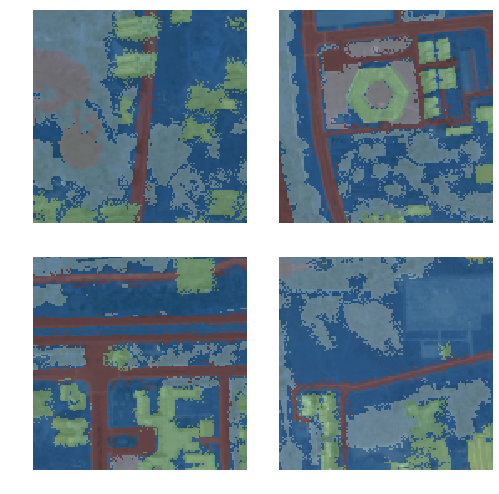

In [0]:
data.show_batch(2, figsize=(7,7))

#### Validation Data in DataBunch Visualization

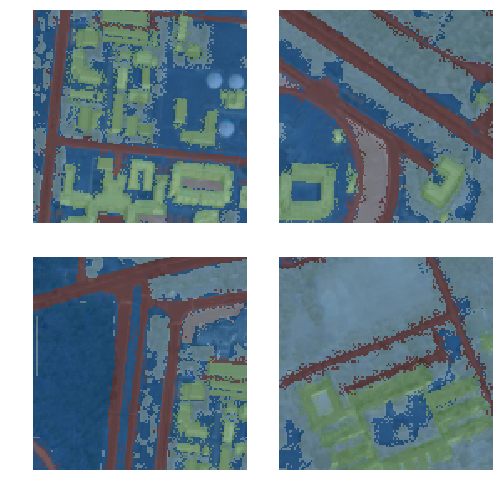

In [0]:
data.show_batch(2, figsize=(7,7), ds_type=DatasetType.Valid)

### Metrics 

####The metrics used are a custom accuracy function and standard Mean IoU metric for segmentation masks.

####The accuracy function takes the labeled parts of the ground truth and only checks those part for accuracy. It leaves the unlabeled parts and does not consider them.

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_sat(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
  

def IOU(input:Tensor, targs:Tensor, iou:bool=True, eps:float=1e-8)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    #i = input.max()
    i = len(codes) - 1 
    res = torch.tensor([0.])
    for j in range(1,i+1):
      inputv = input==j
      inputv = inputv.float()
      targsv = targs==j
      targsv = targsv.float()
      intersect = (inputv * targsv).sum().float()
      union = (inputv + targsv).sum().float()
      if union > 0 :
        res = res + (intersect / (union - intersect + eps))
      else:
        res = res + union.new([1.]).squeeze()
    res = res/i
    return res

In [0]:
metrics = [acc_sat,IOU]
wd = 1e-2

#### Learn is Learner object that takes the data and the model to be used and used to fit the data.

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 16794997.03it/s]


### Learning Rate

Learning rate is a very important hyper-parameter and to find the ideal learning rate for our model we use the lr_find function.
lr_find function plots a graph between the loss and learning rate values. 
The ideal Learning Rate must be chosen by the user and the method is to take the learning rate value at the point it starts increasing and divide it by 10.

---


![alt text](https://cdn-ak.f.st-hatena.com/images/fotolife/n/none53/20190227/20190227081150.png)

---


In the above example image the point after which loss starts exploding is **1e-03** and we divide it by 10 to get **lr = 1e-04** .

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


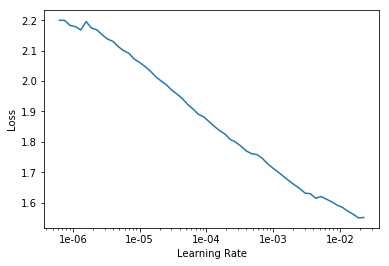

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-3

#### Training the model using the fit_one_cycle

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_sat,IOU,time
0,1.728341,1.808299,0.323573,0.063027,00:06
1,1.572420,1.470793,0.045475,0.037941,00:02
2,1.478296,1.321218,0.449388,0.182855,00:02
3,1.390673,1.179061,0.390914,0.246983,00:02
4,1.333272,1.154505,0.489353,0.303623,00:02
5,1.278077,1.091525,0.589648,0.355048,00:02
6,1.238808,1.053718,0.575774,0.356026,00:02
7,1.197585,0.961141,0.595874,0.427738,00:02
8,1.177547,0.964795,0.639843,0.436218,00:02
9,1.145373,0.990590,0.628347,0.408316,00:02


#### The model can be saved and downloaded to local machine from the files sidebar by assigning the path of learn.save to a variable

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (58 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /content/train_pre;

Valid: LabelList (14 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /content/train_pre;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): M

### Shows the Ground Truth vs Predictions on the Validation Data

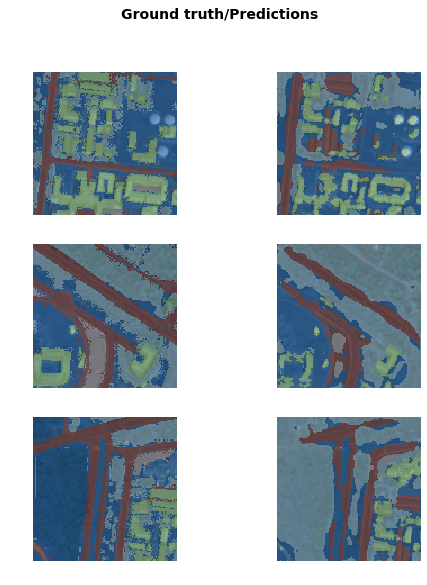

In [0]:
learn.show_results(rows=3, figsize=(8,9))

#### Unfreezing the model to train all the layers now

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_sat,IOU,time
0,0.980910,0.982626,0.656111,0.424658,00:03
1,0.960474,0.937041,0.646660,0.431886,00:03
2,0.938044,0.897069,0.647224,0.443681,00:03
3,0.918714,0.873456,0.657155,0.457830,00:03
4,0.902246,0.885624,0.689642,0.467070,00:03
5,0.890740,0.927383,0.647831,0.437645,00:03
6,0.888978,0.887402,0.674014,0.455090,00:03
7,0.880260,0.842366,0.720375,0.496562,00:03
8,0.869138,0.843242,0.712735,0.491376,00:03
9,0.855203,0.842433,0.703175,0.485093,00:03


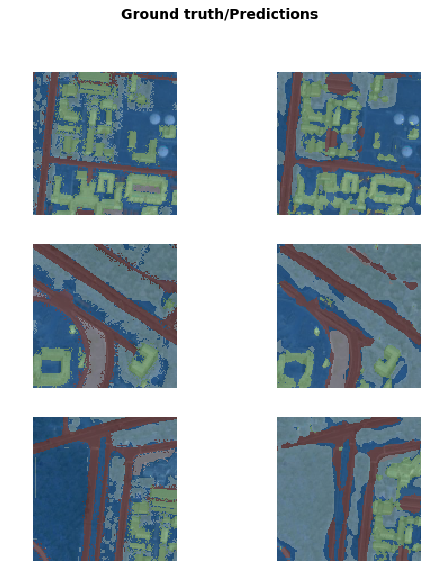

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.save('stage-2');

### Second Run of the Model for double the previous size

In [0]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 11102MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (58 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/train_pre;

Valid: LabelList (14 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/train_pre;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): M

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


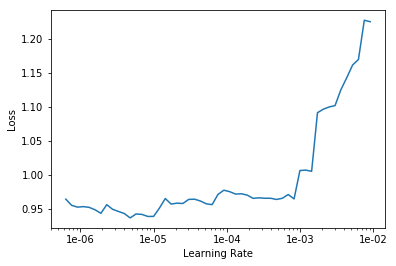

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-4

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_sat,IOU,time
0,0.945356,0.898069,0.700183,0.460965,00:17
1,0.943946,0.907087,0.709784,0.459172,00:09
2,0.916609,0.885399,0.694367,0.455101,00:09
3,0.903872,0.869630,0.700725,0.463269,00:09
4,0.889364,0.861077,0.679085,0.456657,00:09
5,0.880390,0.849243,0.671284,0.458685,00:09
6,0.877358,0.843666,0.663856,0.452618,00:09
7,0.879354,0.839450,0.663438,0.451814,00:09
8,0.869001,0.800219,0.678020,0.476571,00:09
9,0.872569,0.816462,0.707008,0.475095,00:09


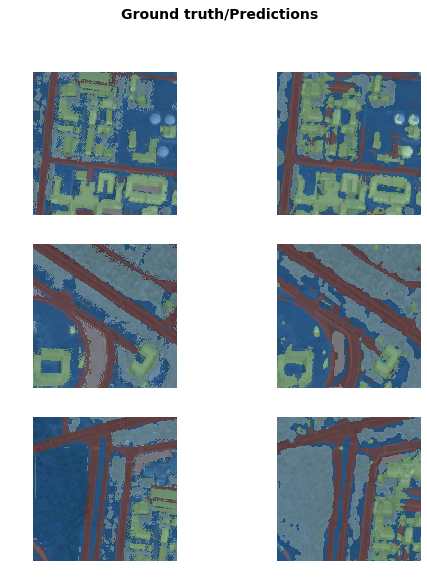

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (58 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/train_pre;

Valid: LabelList (14 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/train_pre;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): M

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_sat,IOU,time
0,0.833176,0.809036,0.710177,0.479372,00:10
1,0.825014,0.813781,0.709078,0.481290,00:10
2,0.806777,0.822138,0.714642,0.481788,00:10
3,0.798876,0.803176,0.727886,0.494044,00:10
4,0.795170,0.799255,0.713415,0.491328,00:10
5,0.786248,0.809133,0.712469,0.489130,00:10
6,0.782531,0.805365,0.713998,0.492044,00:10
7,0.780507,0.801554,0.718149,0.491822,00:10
8,0.778260,0.818493,0.714310,0.485284,00:10
9,0.777327,0.812102,0.714943,0.489760,00:10


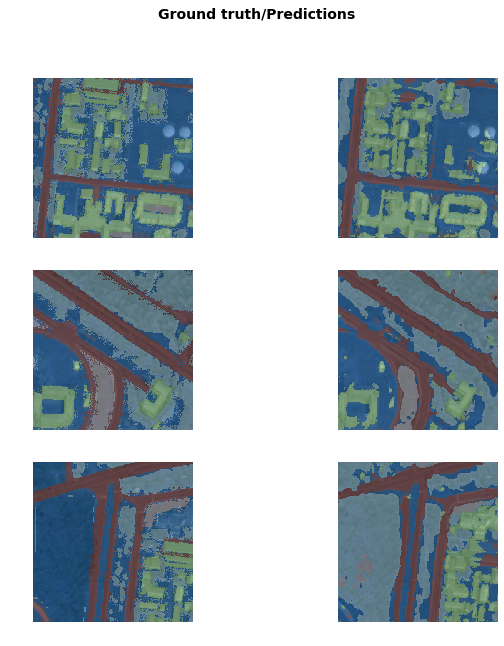

In [0]:
learn.show_results(rows=3, figsize=(10,10))

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (58 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/train_pre;

Valid: LabelList (14 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/train_pre;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): M

In [0]:
learn.data.single_ds.tfmargs['size'] = None
learn.export()

In [0]:
learn = load_learner(path)

FileNotFoundError: ignored